In [1]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional, Conv1D, Concatenate
import matplotlib.pyplot as plt

2025-04-14 19:12:12.919526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set up directories
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

DIRECTORY = '.'
SUMMARY_PATH = 'NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = 'NLP_app/MutualFundLabels.csv'

glove_word2vec = 'NLP_app/word2vec_perso.txt'
our_word2vec = 'NLP_app/word2vec_perso.txt'

# Utility functions
 

In [3]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename, word2vec):
    with open(os.path.join('./', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('./', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    
    # Uses only funds in rag_preds, which are funds with the 3 relevant strategies
    rag_preds = pd.read_csv("rag_predictions.csv")
    relevant_funds = list(rag_preds['fund_name'])
    
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        if fund_name in relevant_funds:
            texts.append(summary)
            fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

## Tokenize fund summaries

In [4]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [5]:
# Get the summaries that use one of the 3 relevant investment strategies
fund_names, summaries = get_data(SUMMARY_PATH)

In [6]:
# Clean and tokenize text - remove whitespace, tokenize words, keep only alphabetic chars, remove stopwords
def tokenizer(txt: str) -> list[str]:
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = []
    for w in word_tokens:
        w_clean = re.sub(r'[^a-zA-Z]', '', w)
        if w_clean and w_clean not in stop_words:
            filtered_sentence.append(w_clean)
    
    return filtered_sentence

In [7]:
# Make one list of all tokenized words from each summary
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

## Set up for skip-gram model

In [8]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [9]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector, also size of hidden layer
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [10]:
# Makes dictionary of words to word frequency for frequency > min_occurrence
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [11]:
# Create id's for each word and create 2 dictionary to access in both directions
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)   

In [12]:
# Create data - list of text_words where words are converted to their id's
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [13]:
# Build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [14]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

## Train the skip-gram model

In [15]:
# Create and compile the Autoencoder
def creat_word2vec_model():
    # One-hot encoded vector input vector
    input_word = Input(shape=(vocab_size,))
    # Embedded layer - maps input vector to embedding vector
    encoded = Dense(embedding_size, activation='linear')(input_word)
    # Output layer - maps embedding vector to probability of a context word
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [16]:
# Create word2vec model
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3105)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       155,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3105)           │       158,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,655 (1.20 MB)

 Trainable params: 313,655 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train model using batch generator
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - loss: 0.0613
Epoch 2/2
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - loss: 0.0024


## Use encoder

In [18]:
# Word to one_hot vecotor to dense vector
def vectorize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [19]:
# Create the word2vec dictionary - dictionary of word to dense vector
word2vec = {w : vectorize(w) for w in word2id.keys()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [20]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec, word2vec)

# C- Sentence extraction

<h3> 1_ Create a knowledge base </h3>

In [21]:
equity_keywords = [
    "equity", "equities", "stock", "stocks", "shares", "common", "capital",
    "appreciation", "growth", "dividends", "midcap",
    "technology", "healthcare", "consumer", "industrials", "portfolio"
]
fixed_income_keywords = [
    "bond", "bonds", "debt", "coupon", "yield", "duration", "interest", "income",
    "fixed", "maturity", "treasury", "municipal", "corporate", "principal", "credit", "rates", "stable"
]
balanced_keywords = [
    "balanced", "diversified", "allocation", "blend", "mix", "strategy",
    "equities", "bonds", "stocks", "fixed", "income", "growth", "capital", 
    "preservation", "stability", "moderate", "hybrid", "rebalancing"
]

In [22]:
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [23]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [24]:
#word2vec = load_word2vec(our_word2vec)
eq_knowledge_base = create_knowledge_base(5, word2vec, equity_keywords)
fi_knowledge_base = create_knowledge_base(5, word2vec, fixed_income_keywords)
bal_knowledge_base = create_knowledge_base(5, word2vec, balanced_keywords)

In [25]:
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv('rag_predictions.csv')
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()

In [26]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [27]:
df['eq_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], eq_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['fi_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], fi_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['bal_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], bal_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [39]:
def combine_extractions(string1, string2, string3):
    li = list(set(sent_tokenize(string1) + sent_tokenize(string2)+ sent_tokenize(string3)))
    return ' '.join(li) 

In [40]:
df['sentences'] = df.apply(lambda x : combine_extractions(x['eq_sentences'], x['fi_sentences'], x['bal_sentences']), axis=1)

,fund_name,Predicted Investment Strategy,Prediction Evidence,Prediction Meta Data,Investment Strategy,Correct?,summary,eq_sentences,fi_sentences,bal_sentences,sentences
0,Thrivent Partner Healthcare Portfolio,Equity Long Only (Low Risk),Thrivent Partner Healthcare Portfolio\n\n<head...,{'source': 'NLP_app/MutualFundSummary/Thrivent...,Equity Long Only (Low Risk),True,Investment Objective\nThrivent Partner Healthc...,"BlackRock Investment Management, LLC, the Port...","BlackRock Investment Management, LLC, the Port...","BlackRock Investment Management, LLC, the Port...",The Portfolio will generally sell a stock when...
1,Federated MDT All Cap Core Fund,Equity Long Only (Low Risk),Federated MDT All Cap Core Fund\n\n<head_break...,{'source': 'NLP_app/MutualFundSummary/Federate...,Equity Long Only (Low Risk),True,Fund Summary Information\nFederated MDT All Ca...,The Adviser implements its strategy using a qu...,The Adviser implements its strategy using a qu...,The Adviser implements its strategy using a qu...,Any short-term losses are used first to offset...
2,Eaton Vance Growth Fund,Equity Long Only (Low Risk),Eaton Vance Growth Fund\n\n<head_breaker>\n\nE...,{'source': 'NLP_app/MutualFundSummary/Eaton Va...,Equity Long Only (Low Risk),True,Eaton Vance Growth Fund\n\nInvestment Objectiv...,The portfolio managers may sell a security whe...,The portfolio managers may sell a security whe...,"In selecting stocks, the portfolio managers co...",The Fund employs a “growth at a reasonable pri...
3,Columbia Large Cap Growth Fund III,Equity Long Only (Low Risk),Columbia Large Cap Growth Fund III <head_breaker>,{'source': 'NLP_app/MutualFundSummary/Columbia...,Equity Long Only (Low Risk),True,SUMMARY OF THE FUND\nInvestment Objective\nCol...,"Box 219104\nKansas City, MO 64121-9104\t \tCol...",There is no guarantee that a financial institu...,There is no guarantee that a financial institu...,"For instance, larger, more\nPROSPECTUS 2018\t5..."
4,Columbia Variable Portfolio - High Yield Bond ...,Fixed Income Long Only (Low Risk),Columbia Variable Portfolio\n\nHigh Yield Bond...,{'source': 'NLP_app/MutualFundSummary/Columbia...,Fixed Income Long Only (Low Risk),True,SUMMARY OF COLUMBIA VP – HIGH YIELD BOND FUND\...,Poor performance may be caused by poor managem...,Interests in secured loans have the benefit of...,"However, the required disclosure is much less ...",Poor performance may be caused by poor managem...
...,...,...,...,...,...,...,...,...,...,...,...
456,U.S. Government/AAA-Rated Securities Fund,Fixed Income Long Only (Low Risk),"Principal investment strategies Normally, the ...",{'source': 'NLP_app/MutualFundSummary/U.S. Gov...,Fixed Income Long Only (Low Risk),True,U.S. Government/AAA-Rated Securities Fund\n\nI...,The contracts for future delivery are normally...,The contracts for future delivery are normally...,The fund is not sold directly to the general p...,While the fund can preserve and generate capit...
457,NORTHERN MONEY MARKET FUND,Fixed Income Long Only (Low Risk),NORTHERN MONEY MARKET FUND\n\n<head_breaker>\n...,{'source': 'NLP_app/MutualFundSummary/NORTHERN...,Fixed Income Long Only (Low Risk),True,FUND SUMMARIES\n\n \n\nMONEY MARKET FUND\n\n \...,For the current 7-day yield call 800-595-9111 ...,A natural person is an individual human being ...,∎\t \t\nBy Systematic Withdrawal – If you own ...,For the current 7-day yield call 800-595-9111 ...
458,American Funds College 2018 Fund,Balanced Fund (Low Risk),Principal investment strategies The fund will ...,{'source': 'NLP_app/MutualFundSummary/American...,Balanced Fund (Low Risk),True,American Funds College 2018 Fund\n\nInvestment...,It is anticipated that the merger will be cons...,It is anticipated that the merger will be cons...,It is anticipated that the merger will be cons...,It is anticipated that the merger will be cons...
459,Ivy Global Equity Income Fund,Equity Long Only (Low Risk),Principal Investment Strategies\n\nIvy Global ...,{'source': 'NLP_app/MutualFundSumm

In [41]:
df.to_csv("dataset2.csv")

## Prepare data for models

In [43]:
X = df['sentences'].values
# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'shortterm losses used first offset shortterm gains active trading strategy likely result fund genera'

In [44]:
y = df['Predicted Investment Strategy'].values
y = np.array([2 if x=='Equity Long Only (Low Risk)' else (1 if x=='Fixed Income Long Only (Low Risk)' else 0) for x in y])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Preprocessing Hyperparameters

In [50]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

word2vec_g = load_word2vec(our_word2vec)

In [51]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

In [53]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Create CNN

In [74]:
def create_CNN_model(filters1=64, filters2=32, kernel_size=5, pool_size=5, dense_units=128, dropout_rate=0.5):
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(filters1, kernel_size, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size=pool_size))

    CNN.add(Convolution1D(filters2, kernel_size, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size=pool_size))

    CNN.add(Flatten())
    CNN.add(Dense(units = dense_units , activation = 'relu'))
    CNN.add(Dropout(dropout_rate))
    ### CHANGED FROM EXAMPLE - 3 and softmax
    CNN.add(Dense(units = 3, activation = 'softmax'))

    ### CHANGED LOSS
    CNN.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [75]:
CNN_model = create_CNN_model()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [76]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4737 - loss: 1.0717 - val_accuracy: 0.4839 - val_loss: 1.0595
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5121 - loss: 1.0364 - val_accuracy: 0.4839 - val_loss: 1.0511
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5613 - loss: 0.9949 - val_accuracy: 0.4839 - val_loss: 1.0567
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5278 - loss: 1.0215 - val_accuracy: 0.4839 - val_loss: 1.0835
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5167 - loss: 1.0279 - val_accuracy: 0.5054 - val_loss: 1.0485
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5485 - loss: 0.9830 - val_accuracy: 0.4839 - val_loss: 1.0374
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5598 - loss: 0.9764 - val_accuracy: 0.4839 - val_loss: 1.0474
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5387 - loss: 0.9791 - val_accuracy: 0.4946 - val_loss

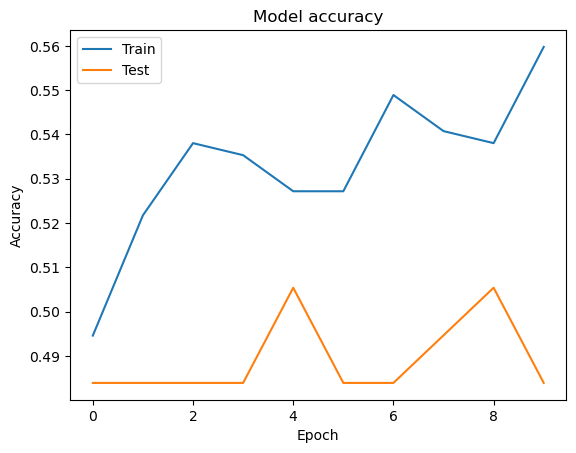

In [77]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [81]:
import numpy as np
from itertools import product
from tensorflow.keras.callbacks import EarlyStopping

# Define your grid
filters1_list = [64, 128]
filters2_list = [32, 64]
kernel_size_list = [3, 5]
pool_size_list = [2, 5]
dense_units_list = [64, 128]
dropout_rate_list = [0.3, 0.5]

# Track results
results = []

# Loop over all combinations
for filters1, filters2, kernel_size, pool_size, dense_units, dropout_rate in product(
        filters1_list, filters2_list, kernel_size_list,
        pool_size_list, dense_units_list, dropout_rate_list):

    print(f"Training with filters1={filters1}, filters2={filters2}, kernel_size={kernel_size}, "
          f"pool_size={pool_size}, dense_units={dense_units}, dropout_rate={dropout_rate}")

    # Create model
    model = create_CNN_model(
        filters1=filters1,
        filters2=filters2,
        kernel_size=kernel_size,
        pool_size=pool_size,
        dense_units=dense_units,
        dropout_rate=dropout_rate
    )

    # Fit model with early stopping
    history = model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

    # Evaluate
    val_accuracy = history.history['val_accuracy'][-1]
    results.append({
        'filters1': filters1,
        'filters2': filters2,
        'kernel_size': kernel_size,
        'pool_size': pool_size,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'val_accuracy': val_accuracy
    })

# Sort and show best result
results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
print("\nBest configuration:")
print(results[0])

Training with filters1=64, filters2=32, kernel_size=3, pool_size=2, dense_units=64, dropout_rate=0.3
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4757 - loss: 1.0697 - val_accuracy: 0.4839 - val_loss: 1.0575
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5339 - loss: 0.9942 - val_accuracy: 0.4839 - val_loss: 1.0310
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5371 - loss: 0.9872 - val_accuracy: 0.5054 - val_loss: 1.0225
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6001 - loss: 0.9203 - val_accuracy: 0.5591 - val_loss: 0.9942
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6291 - loss: 0.9071 - val_accuracy: 0.5376 - val_loss: 0.9524
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6266 - loss: 0.8861 - val_accuracy: 0.5161 - val_loss: 0.8986
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6448 - loss: 0.7634 - val_accuracy: 0.5806 - val_loss: 0.8531
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6061 - loss: 0.7876 - val_accuracy: 0.5914 - val_loss: 0.902